In [79]:
import numpy as np
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import sys

import argparse, os, math, pickle, json

# 1) Load your model
from dual_alm_rnn_models import *
from dual_alm_rnn_exp import DualALMRNNExp
plt.rcParams['pdf.fonttype'] = '42' 


In [95]:
def get_cosine_similarity(a, b):

    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

recurrent_optimal = np.array([1.0, -1.0, -1.0, 1.0], dtype=np.float32)
recurrent_optimal_plusreadout = np.concatenate([recurrent_optimal, [-1, 1]])

In [88]:
exp=DualALMRNNExp()


# Load configs to get model parameters
with open('dual_alm_rnn_configs.json', 'r') as f:
    configs = json.load(f)

model = getattr(sys.modules[__name__], configs['model_type'])(configs, \
    exp.a, exp.pert_begin, exp.pert_end, noise=True)

model_path = '/Users/catherinewang/Desktop/RNN/Dual_ALM_RNN/dual_alm_rnn_models/TwoHemiRNNTanh_single_readout/train_type_asymmetric_fixed_input_mult_seeds/n_neurons_4_random_seed_3/unfix_epoch_1/n_epochs_40_n_epochs_across_hemi_0/lr_3.0e-03_bs_75/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_1.00_right_alm_amp_1.00/init_cross_hemi_rel_factor_0.20/model_epoch_30.pth'
# checkpoint_path = os.path.join(model_path.format(seed, unfix_epoch), checkpoint_file)
# if not os.path.exists(checkpoint_path):
#     raise FileNotFoundError(f"Model checkpoint not found at {checkpoint_path}")

state_dict = torch.load(model_path, map_location='cpu', weights_only=True)
model.load_state_dict(state_dict)
print(model.rnn_cell.w_hh_linear_ll.weight.data.cpu().numpy())
print(model.readout_linear.weight.data.cpu().numpy())

Fixed input weights for left and right ALM
[[ 1.5 -0.3]
 [-0.3  1.5]]
[[-2.0420127   2.0418694  -0.19284172 -0.14140457]]


# Add pre-learned hemi:

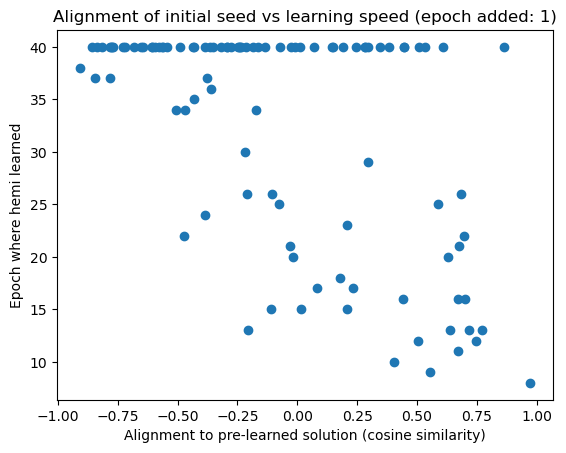

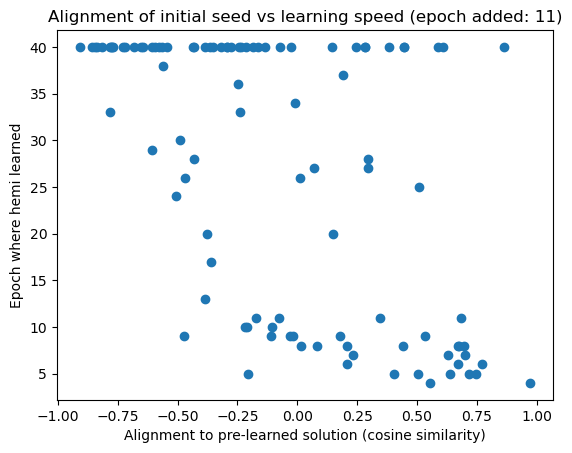

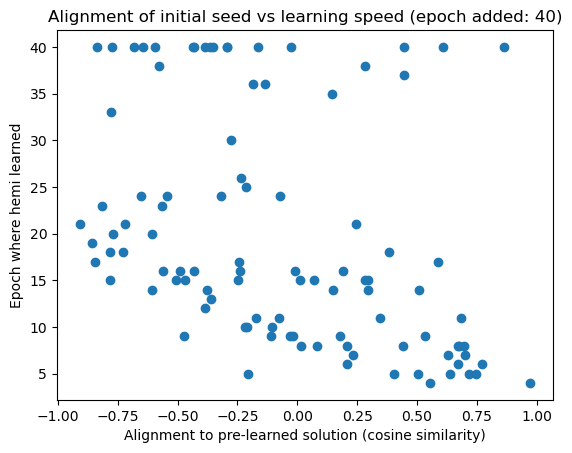

In [98]:
all_alignments = []
for unfix_epoch in [1, 11, 40]:
    readout_bias = np.load('test/figs/epoch_{}/all_readout_bias.npy'.format(unfix_epoch))
    readout_weights = np.load('test/figs/epoch_{}/all_readout_weights.npy'.format(unfix_epoch))
    recurrent_weights = np.load('test/figs/epoch_{}/all_recurrent_weights.npy'.format(unfix_epoch))
    recurrent_bias = np.load('test/figs/epoch_{}/all_recurrent_bias.npy'.format(unfix_epoch))
    learning_epoch = np.load('test/figs/epoch_{}/all_learning_epoch.npy'.format(unfix_epoch))

    alignments = []
    for i in range(len(recurrent_weights)):
        alignments.append(get_cosine_similarity(recurrent_weights[i].flatten(), recurrent_optimal))

    plt.scatter(alignments, learning_epoch)
    plt.xlabel('Alignment to pre-learned solution (cosine similarity)')
    plt.ylabel('Epoch where hemi learned')
    plt.title('Alignment of initial seed vs learning speed (epoch added: {})'.format(unfix_epoch))
    plt.show()

    # alignments_plusreadout = []
    # for i in range(len(recurrent_weights)):
    #     alignments_plusreadout.append(get_cosine_similarity(np.concatenate([recurrent_weights[i].flatten(), readout_weights[i].flatten()[:2]]), recurrent_optimal_plusreadout))

    # plt.scatter(alignments_plusreadout, learning_epoch)
    # plt.xlabel('Alignment to pre-learned solution (cosine similarity)')
    # plt.ylabel('Epoch where hemi learned')
    # plt.title('Alignment + readout of initial seed vs learning speed (epoch added: {})'.format(unfix_epoch))
    # plt.show()
    

    # plt.plot(learning_epoch)
    # plt.title('Learning Epoch for Unfix Epoch {}'.format(unfix_epoch))
    # plt.show()

# Add cross-hemi weights

Test if alignment of hemispheres affects speed up

In [103]:
all_alignments = []
for unfix_epoch in [0,10,20,40]:
    left_asymm, right_asymm = 1.0, 1.0
    # all_readout_bias = np.load('test/figs/crosshemi/epoch_{}/left_asymm_{}_right_asymm_{}/all_readout_bias.npy'.format(unfix_epoch, left_asymm, right_asymm))
    # np.load('test/figs/crosshemi/epoch_{}/left_asymm_{}_right_asymm_{}/all_readout_weights.npy'.format(unfix_epoch, left_asymm, right_asymm), all_readout_weights)
    recurrent_weights_r = np.load('test/figs/crosshemi/epoch_{}/left_asymm_{}_right_asymm_{}/all_recurrent_weights_r.npy'.format(unfix_epoch, left_asymm, right_asymm))
    recurrent_weights_l = np.load('test/figs/crosshemi/epoch_{}/left_asymm_{}_right_asymm_{}/all_recurrent_weights_l.npy'.format(unfix_epoch, left_asymm, right_asymm))
    # np.load('test/figs/crosshemi/epoch_{}/left_asymm_{}_right_asymm_{}/all_crosshemi_rl.npy'.format(unfix_epoch, left_asymm, right_asymm), all_crosshemi_rl)
    # np.load('test/figs/crosshemi/epoch_{}/left_asymm_{}_right_asymm_{}/all_crosshemi_lr.npy'.format(unfix_epoch, left_asymm, right_asymm), all_crosshemi_lr)
    # np.load('test/figs/crosshemi/epoch_{}/left_asymm_{}_right_asymm_{}/all_recurrent_bias.npy'.format(unfix_epoch, left_asymm, right_asymm), all_recurrent_bias)
    learning_epoch = np.load('test/figs/crosshemi/epoch_{}/left_asymm_{}_right_asymm_{}/all_learning_epoch_r.npy'.format(unfix_epoch, left_asymm, right_asymm))

    alignments = []
    for i in range(len(recurrent_weights)):
        alignments.append(get_cosine_similarity(recurrent_weights_r[i].flatten(), recurrent_weights_l[i].flatten()))

    plt.scatter(alignments, learning_epoch)
    plt.xlabel('Alignment of hemispheres (cosine similarity)')
    plt.ylabel('Epoch where R hemi learned')
    plt.title('Alignment of hemispheres vs learning speed (epoch added: {})'.format(unfix_epoch))
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'test/figs/crosshemi/epoch_0/left_asymm_1.0_right_asymm_1.0/all_learning_epoch_r.npy'